In [29]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score, f1_score
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Base line functions

In [6]:
def get_AR_predictions(training, n_periods):
    temp_model = AR(training) 
    fit_model = temp_model.fit()
    preds = fit_model.predict(len(training),len(training) + n_periods -1)
    return np.array(preds)

def get_MA_predictions(training, n_periods):
    temp_model = ARMA(training, order=(0, 1))
    fit_model = temp_model.fit(disp=False)
    preds = fit_model.predict(len(training),len(training) + n_periods - 1)
    return np.array(preds)

def get_ARMA_predictions(training, n_periods):
    temp_model = ARMA(training, order=(2, 1))
    fit_model = temp_model.fit(disp=False)
    preds = fit_model.predict(len(training),len(training) + n_periods - 1)
    return np.array(preds)

def get_ARIMA_predections(training, n_periods):
    model = pm.auto_arima(training, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      disp = False)
    model.fit(training)
    preds = model.predict(n_periods=n_periods)
    return preds

def train_test_split(stock_df, training_days, prediction_days):
    training = stock_df.iloc[-(training_days + prediction_days):-prediction_days, :]['Close']
    testing = stock_df.iloc[-prediction_days:, :]['Close']
    return training, testing 

def get_complex_future_trend_prediction_baseline(stock_df, predictions):
    future_trends ={x:'do somthing' for x in ['week_changes','month_changes','quarter_changes','year_changes']}
    indiffrence_ranges = {x:[] for x in ['week_changes','month_changes','quarter_changes','year_changes']}
    
    first_price = np.array(stock_df['Open'])[-1]
    final_vals = predictions
    changes = get_frequant_changes(stock_df)
    
    for k, l in zip(future_trends.keys(), [5,25,75,250]):
        temp_change = ((final_vals[l -1] - first_price) / first_price) * 100
        if l in [5,25]:
            if np.quantile(changes[k], 0.15) <= temp_change <= np.quantile(changes[k], 0.85):
                future_trends[k] = 'HOLD'
            elif temp_change < np.quantile(changes[k], 0.15):
                future_trends[k] = 'HARD SELL'
            else:
                future_trends[k] = 'HARD BUY'
        else: # quarter and year changes
            if np.quantile(changes[k], 0.15) <= temp_change <= np.quantile(changes[k], 0.85): #holding range
                if l == 75: #quarter
                    if temp_change > 5:
                        future_trends[k] = 'HARD BUY'
                    else:
                        future_trends[k] = 'HOLD'
                else: #year
                    if temp_change > 10:
                        future_trends[k] = 'HARD BUY'
                    else:
                        future_trends[k] = 'HOLD'
            elif temp_change < np.quantile(changes[k], 0.15):
                future_trends[k] = 'HARD SELL'
            else:
                future_trends[k] = 'HARD BUY'
    return future_trends

## HMM functions

In [1]:
def enumerate_features(data):
    """
    :param data: the data vector in np.array format
    :return: a dictionary that enumerates each value into a corresponding number (for the probability tables)
    """
    feature_enumerator = {}
    reverse_enumerator = {}
    counter = 0
    for instance in data:
        if instance not in feature_enumerator.keys():
            feature_enumerator[instance] = counter
            reverse_enumerator[counter] = instance
            counter += 1
    return feature_enumerator, reverse_enumerator


def forward(mat_A, mat_B, vec_pi, data, feature_enumerator):
    """
    :param mat_A: probabilities between hidden variables
    :param mat_B: probabilities from hidden to known variables
    :param vec_pi: starting probability vector
    :param data: the data vector
    :param feature_enumerator: enumeration dictionary of the data labels
    :return: calculated alpha (the alpha parameter for each iteration) and normalization vector
    """
    # initialize the alpha matrix
    size = (np.shape(mat_A)[0], np.shape(data)[0])
    mat_alpha = np.zeros(size)
    # initialize norm vector
    normalization_factor = np.ones((size[1]))
    # run the forward algo
    for i in range(size[1]):
        normalization_factor[i] = 0
        for j in range(size[0]):
            if i > 0:
                mat_alpha[j, i] = mat_B[j, feature_enumerator[data[i]]] * np.sum(mat_alpha[:, i-1] * mat_A[:, j])
            else:
                # initialization of the first row (dependant on the pi vector and not previous rows)
                mat_alpha[:, 0] = vec_pi * mat_B[:, feature_enumerator[data[0]]]
        normalization_factor[i] = 1.0/np.sum(mat_alpha[:, i])
        mat_alpha[:, i] *= normalization_factor[i]

    return mat_alpha, normalization_factor


def backward(mat_A, mat_B, data, feature_enumerator, normalization_factor):
    """
    :param mat_A: probabilities between hidden variables
    :param mat_B: probabilities from hidden to known variables
    :param data: the data vector
    :param feature_enumerator: enumeration dictionary of the data labels
    :param normalization_factor: the normalization factor from the forward function
    :return: calculated beta (the beta parameter for each iteration)
    """
    # initialization of the beta matrix
    size = (np.shape(mat_B)[0], np.shape(data)[0])
    mat_beta = np.zeros(size)
    # run the backward algo
    for i in range(size[1]-1, -1, -1):
        if i < size[0] - 1:
            for j in range(size[0]):
                mat_beta[j, i] = np.sum(mat_B[:, feature_enumerator[data[i+1]]] * mat_beta[:, i+1] * mat_A[j, :])
                # scale to the same normalization factor in the forward:
                mat_beta[j, i] *= normalization_factor[i]
        else:
            # initialization of the last row
            mat_beta[:, i] = normalization_factor[i]
    return mat_beta


def viterbi(mat_A, mat_B, data, vec_pi, feature_enumerator):
    """
    :param mat_A: probabilities between hidden variables
    :param mat_B: probabilities from hidden to known variables
    :param vec_pi: starting probability vector
    :param data: the data vector
    :param feature_enumerator: enumeration dictionary of the data labels
    :return:
    """
    size = (np.shape(mat_B)[0], np.shape(data)[0])

    path = np.zeros(size[1])
    mat_delta = np.zeros(size)
    mat_phi = np.zeros(size)

    mat_delta[:, 0] = vec_pi * mat_B[:, feature_enumerator[data[0]]]

    for i in range(size[1]):
        for j in range(size[0]):
            mat_delta[j, i] = np.max(mat_delta[:, i-1] * mat_A[:, j]) * mat_B[j, feature_enumerator[data[i]]]
            mat_phi[j, i] = np.argmax(mat_delta[:, i-1] * mat_A[:, j])

    path[size[1] - 1] = np.argmax(mat_delta[:, size[1]-1])
    for i in range(size[1] - 2, -1, -1):
        path[i] = mat_phi[int(path[i+1]), i+1]

    return path, mat_delta, mat_phi


def baum_welch (data, n, feature_enumerator, random = 1, tolerance = 1e-6, max_iter = 10000):
    """
    :param data: the data vector
    :param n: amount of hidden variables
    :param feature_enumerator: enumeration dictionary of the data labels
    """

    size = np.shape(data)[0]
    num_of_values_in_data = int(max(feature_enumerator.values())) + 1
    digamma = np.zeros((n, n, size))
    np.random.seed(random)

    # initialization using dirichlet
    vec_pi = np.ndarray.flatten(np.random.dirichlet(np.ones(n), size=1))
    mat_a = np.random.dirichlet(np.ones(n), size=n)
    mat_b = np.random.dirichlet(np.ones(num_of_values_in_data), size=n)
    
    #initialize error based on the tolerance
    error = tolerance + 10
    itter = 0
    while ((error > tolerance) & (itter < max_iter)):
        former_a = mat_a.copy()
        former_b = mat_b.copy()
        alpha, norm = forward(mat_a, mat_b, vec_pi, data, feature_enumerator)
        beta = backward(mat_a, mat_b, data, feature_enumerator, norm)
        for i in range(size - 1):
            for j in range(n):
                for k in range(n):
                    digamma[j, k, i] = alpha[j, i] * mat_a[j, k] * mat_b[k, feature_enumerator[data[i + 1]]] * beta[k, i+1]
            digamma[:, :, i] /= np.sum(digamma[:, :, i])

        for i in range(n):
            for j in range(n):
                digamma[i, j, size - 1] = alpha[i, size - 1] * mat_a[i, j]
        digamma[:, :, size - 1] /= np.sum(digamma[:, :, size - 1])

        for i in range(n):
            vec_pi[i] = np.sum(digamma[i, :, 0])
            for j in range(n):
                mat_a[j, i] = np.sum(digamma[i, j, :size - 1]) / np.sum(digamma[i, :, :size - 1])

            for j in range(num_of_values_in_data):
                for k in range(size):
                    if feature_enumerator[data[k]] == j:
                        mat_b[i, j] += np.sum(digamma[i, :, k]) / np.sum(digamma[i, :, :])

        error = (np.abs(mat_a - former_a)).max() + (np.abs(mat_b - former_b)).max()
        itter += 1
    for i in range(n):
        mat_b[i, :] /= np.sum(mat_b[i, :])
    mat_a = np.transpose(mat_a)
    return mat_a, mat_b, vec_pi, alpha


def choose_next(path, data, reverse_enumerator, enumerator, a, b, random = 1):
    temp_data = data.copy()
    temp_path = path.copy()
    last_hidden = int(temp_path[np.size(data)-1])
    if random == 1:
        best_hidden = np.random.choice(len(a[last_hidden, :]), 1, p=a[last_hidden, :])[0]
        new_path = np.append(temp_path, [best_hidden])
        best_result = np.random.choice(len(enumerator.keys()), 1, p=b[best_hidden, :])[0]
        new_data = np.append(temp_data, [reverse_enumerator[best_result]])
    else:
        best_hidden = [0, 0]
        for j in range(len(a[last_hidden, :])):
            if a[last_hidden, j] > best_hidden[1]:
                best_hidden = [j, a[last_hidden, j]]
        new_path = np.append(temp_path, [best_hidden[0]])
        best_result = [0, 0]
        for j in range(len(enumerator.keys())):
            if b[best_hidden[0], j] > best_result[1]:
                best_result = [j, b[best_hidden[0], j]]
        new_data = np.append(temp_data, [reverse_enumerator[best_result[0]]])
    return new_path, new_data


def predict(n, k, data, enumerator, reverse_enumerator, prediction = "simple", random = 1, seed = 0):
    np.random.seed(seed)
#     print('baum welcing...')
    a, b, pi, alpha = baum_welch(data, k, enumerator)
#     print('viterbing...')
    path, delta, phi = viterbi(a, b, data, pi, enumerator)
    new_data = data.copy()
    new_path = path.copy()
    last_index = np.size(data)-1
    if prediction == "simple":
        for i in range(n):
            new_path, new_data = choose_next(new_path, new_data, reverse_enumerator, enumerator, a, b, random=random)
        return new_data
    else:
        for i in range(n):
            new_path, new_data = choose_next(new_path, new_data, reverse_enumerator, enumerator, a, b, random=random)
            new_path, delta, phi = viterbi(a, b, new_data, pi, enumerator)
        return new_data

## Data functions

In [8]:
def get_ETF_data(data_length):
    """
    :return: DataFrame dictionary containing data of ETF's with 10+ years worth of data key:ETF name, val: dataframe
    """
    df_dict = {}
    directory = os.fsencode('ETFs')
    counter = 0
    for file in os.listdir(directory):
        if counter > data_length:
            break
        filename = os.fsdecode(file)
        temp_df = pd.read_csv('ETFs/'+filename)
        if len(temp_df) > 3000 and 0 not in temp_df['Open'].values:
            del temp_df['OpenInt'] #useless variable
            temp_df = symbolise_df(temp_df) # add column of matching symbol
            temp_df['Year'] = [int(x[:4])  for x in temp_df['Date']]
            temp_df['Two_Symbols'] = [x[0]+x[-1] for x in temp_df['Symbol']]
            temp_df = temp_df[temp_df['Year'] >= 2010]
            df_dict[filename[0:-7]] = temp_df
            counter+= 1
    return df_dict

def get_stock_data(relevant_stocks):
    """
    :return: DataFrame dictionary containing data of stocks with 10+ years worth of data key:ETF name, val: dataframe
    """
    df_dict = {}
    directory = os.fsencode('Stocks')
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        temp_name = str(filename[0:-7])
        if temp_name in relevant_stocks:
            temp_df = pd.read_csv('Stocks/'+filename)
            if len(temp_df) > 1750:
                del temp_df['OpenInt'] #useless variable
                temp_df = symbolise_df(temp_df) # add column of matching symbol
                temp_df['Year'] = [int(x[:4])  for x in temp_df['Date']]
                temp_df['Two_Symbols'] = [x[0]+x[-1] for x in temp_df['Symbol']]
                temp_df = temp_df[temp_df['Year'] >= 2010]
                df_dict[filename[0:-7]] = temp_df
    return df_dict

def get_new_fracs_and_bins(stock_df, num_bins):
    """
    :param stock_df:  dataframe containg stock trading data
    :param num_bins:  number of symbols to use
    :return: column stack array of "price" ,"high- low" and "open vs close "symbols with matching bins
    """
    open_p = np.array(stock_df['Open'])
    close_p = np.array(stock_df['Close'])
    high_p = np.array(stock_df['High'])
    low_p = np.array(stock_df['Low'])

    frac_price = (close_p - open_p) / open_p
    frac_high_low = (high_p - low_p) / open_p
    frac_open_close = np.array([0] + [(open_p[i] - close_p[i - 1]) / close_p[i - 1] for i in range(1, len(open_p))])

    labels = ['L', 'A', 'M', 'H'] if num_bins == 4 else ['L', 'M', 'H']
    price_symbols, price_bins = pd.qcut(frac_price, num_bins, labels=labels, retbins=True)
    high_low_symbols = pd.qcut(frac_high_low, num_bins, labels=labels)
    open_close_symbols, open_close_bins = pd.qcut(frac_open_close, num_bins, labels=labels, retbins=True)

    return np.column_stack((price_symbols, high_low_symbols, open_close_symbols)), price_bins, open_close_bins


def get_symbols(bins_data):
    """
    :param bind_data: column stack array of "price" ,"high- low" and "open vs close "symbols
    :return: string containing matching symbols
    """
    string_list = []
    for row in bins_data:
        temp_string = ''
        for col in row:
            temp_string += str(col)
        string_list.append(temp_string)
    return string_list


def symbolise_df(stock_df):
    """
    :param stock_df: stock dataframe
    :return: adds column of "Symbol" to the dataframe
    """
    bins_data, price_bins, open_close_bins = get_new_fracs_and_bins(stock_df, 3)
    stock_df['Symbol'] = get_symbols(bins_data)
    return stock_df


def get_training_symbols(stock_df, num_learning, num_symbols):
    """
    :param df: stock dataframe
    :param frac_learning: number of data rows used for learning
    :return: training symbols
    """
    if num_symbols == 3:
        return stock_df.iloc[-(num_learning+250):-250, :]['Symbol'].values #data for learning
    return stock_df.iloc[-(num_learning+250):-250, :]['Two_Symbols'].values #data for learning


## Reverse ploting functions

In [9]:
def get_tricky_fracs(stock_df, labels, frac_type):
    open_p = np.array(stock_df['Open'])
    close_p = np.array(stock_df['Close'])
    
    frac_price = (close_p - open_p) / open_p
    frac_open_close = np.array([0]+[(open_p[i] - close_p[i-1]) / close_p[i-1] for i in range(1,len(open_p))])

    price_symbols = pd.qcut(frac_price, 3, labels = labels)
    open_close_symbols = pd.qcut(frac_open_close, 3, labels = labels)

    if frac_type == 'price':
         return  pd.DataFrame(np.column_stack((frac_price, price_symbols)),columns=['frac','symbol'])
    if frac_type == 'open_close':
        return  pd.DataFrame(np.column_stack((frac_open_close, open_close_symbols)),columns=['frac','symbol'])

In [10]:
def get_gaussian_symbol_dic(stock_df, labels, frac_type):
    symbols_dic = {}
    temp_df = get_tricky_fracs(stock_df, labels, frac_type)
    for l in labels:
        temp_bin = temp_df[temp_df['symbol'] == l]['frac'].values
        symbols_dic[l] = [np.mean(temp_bin), np.std(temp_bin)]
    return symbols_dic

In [11]:
def get_series_from_gaussian_symbols(stock_df, predicted):
    translated_close_price = []
    labels = ['L','M','H']
    price_symbol_dic = get_gaussian_symbol_dic(stock_df, labels, 'price')
    open_close_symbol_dic = get_gaussian_symbol_dic(stock_df, labels, 'open_close')
    
    current_val = np.array(stock_df['Open'])[-1] #start predicting from the last known open price
    for p in predicted:
        p_s, oc_s = p[0], p[-1] #get symbols from prediction
        #p_s, oc_s = p[0], p[1] # to work with upgraded method
        temp_price_change = np.random.normal(price_symbol_dic[p_s][0], price_symbol_dic[p_s][1]) #sample from relevant distribution
        temp_openclose_change = np.random.normal(open_close_symbol_dic[oc_s][0], open_close_symbol_dic[oc_s][1]) #sample from relevant distribution
        
        first_temp_translation = current_val * (1 + temp_openclose_change)
        final_tmep_val = first_temp_translation * (1 + temp_price_change)
        translated_close_price.append(final_tmep_val)
        current_val = final_tmep_val
    return translated_close_price 

In [12]:
def translate(stock_df, predictions, num_tryes):
    reverse_translations = {}
    for i in range(num_tryes):
        reverse_translations[i] = np.array(get_series_from_gaussian_symbols(stock_df, predictions))
    return sum(reverse_translations.values()) /  num_tryes   

In [13]:
def get_MAPE_score(true_vals, predicted_vals):
    return np.mean(np.abs((true_vals - predicted_vals) / true_vals)) * 100

In [14]:
def plot_graphs_and_predictions(k,training_days,predictions_dict, etf_dict):
    temp_df = etf_dict[k[0]].iloc[-(training_days + 250):-250, :]
    true_vals = etf_dict[k[0]].iloc[-250:,:]
    final_vals = translate(temp_df, predictions_dict[k], 100)
    translated = pd.DataFrame(final_vals,index = true_vals['Close'].index,columns=['Prediction'])
    plt.figure(figsize=(16,8))
    plt.plot(temp_df['Close'], label='Training Period', color = 'b')
    plt.legend(loc='upper left')
    plt.plot(true_vals['Close'], label='True Vlues', color = 'g')
    plt.legend(loc='upper left')
    plt.plot(translated['Prediction'], label = 'Predicted Values', color = 'black')
    plt.legend(loc='upper left')
    plt.title(k)

In [11]:
def plot_graphs_and_true_vals(etf, etf_dict, training_days, prediction_days):
    temp_df = etf_dict[etf].iloc[-(training_days + prediction_days):-prediction_days, :]
    true_vals = etf_dict[etf].iloc[-prediction_days:,:]
    plt.figure(figsize=(16,8))
    plt.plot(temp_df['Close'], label='Close Price history', color = 'b')
    plt.plot(true_vals['Close'], label='Close Price history', color = 'g')
    plt.title(etf)

# Base line Comparison #

We begin with some basic Time Series models including Auto Regression, Moving Average, ARMA, and ARIMA to predict 10 selected ETFs one year into the future and get some perspective about their performance.

We do so by comparing the overall MAPE (Mean Absolute Percentage Erroe) scores of the various ETFs achieved by the different methods:

In [15]:
etf_dict = get_ETF_data(200)
etfs = ['xlk','jkl', 'xle', 'kce', 'kie','ewz','gld','spy','xlf','fvl']

In [ ]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm

mape_scores = {}
baseline_preds = {}
prediction_days = 250
for etf in etfs:
    for l in [1000]:
        temp_df = etf_dict[etf]
        temp_train, temp_test = train_test_split(temp_df, l,prediction_days)

        AR_preds = get_AR_predictions(temp_train, prediction_days)
        baseline_preds[(etf,'AR',l)] = AR_preds
        mape_scores[(etf,'AR',l)] = get_MAPE_score(temp_test,AR_preds)
        
        MA_preds = get_MA_predictions(temp_train, prediction_days)
        baseline_preds[(etf,'MA',l)] = MA_preds
        mape_scores[(etf,'MA',l)] = get_MAPE_score(temp_test,MA_preds)
    
        ARMA_preds = get_ARMA_predictions(temp_train, prediction_days)
        baseline_preds[(etf,'ARMA',l)] = ARMA_preds
        mape_scores[(etf,'ARMA',l)] = get_MAPE_score(temp_test, ARMA_preds) 

        ARIMA_preds = get_ARIMA_predections(temp_train, prediction_days)
        baseline_preds[(etf,'ARIMA',l)] = ARIMA_preds
        mape_scores[(etf,'ARIMA',l)] = get_MAPE_score(temp_test, ARIMA_preds)

In [16]:
total_base_scores = {y:0 for y in ['AR','MA','ARMA','ARIMA']}

for k,val in mape_scores.items():
    total_base_scores[k[1]] += val

for k,val in total_base_scores.items():
    print('Method:',k,',Total MAPE score: ', val)

Method: AR ,Total MAPE score:  102.32480308263949
Method: MA ,Total MAPE score:  182.5093396171745
Method: ARMA ,Total MAPE score:  97.21843030197299
Method: ARIMA ,Total MAPE score:  76.45269914058743


# Basic Part

## Best Model configuration comparison
In these sections, we will try to find the optimal parameters for our model by comparing the total prediction error over 10 ETF's. We do so by comparing the overall MAPE (Mean Absolute Percentage Erroe) scores of the various ETFs achieved by the different models.

## Feature engineering

In [ ]:
final_scores = {}
predictions = {}
hidden_states = 2
for etf in etfs:
    for num_symbols in [2,3]:
        for training_days in [500,1000,1500]:
            #training
            start = time.time()
            training =  get_training_symbols(etf_dict[etf], training_days, num_symbols)
            
            temp_enu, temp_reverse_enu = enumerate_features(training)
            predicted_data = predict(250, hidden_states, training, temp_enu, temp_reverse_enu) #predict 250 days into the future
            predicted = predicted_data[-250:]
            end = time.time()
            predictions[(etf,num_symbols,training_days)] = predicted
            print(num_symbols, 'symbols', training_days,' training days, etf name: ',etf,' training time is: ', end - start)

            #prediction and translation       
            temp_df = etf_dict[etf].iloc[-(training_days + 250):-250, :]
            temp_true_vals = etf_dict[etf].iloc[-250:,:]['Close'].values
            final_vals = translate(temp_df, predicted, 100) #number of bootstrap iterations = 100

            file_name = open(str(etf) +'_'+ str(num_symbols) +'_'+ str(training_days) +'_days', 'wb')
            pickle.dump(predicted, file_name)
            #score calculation
            temp_score = get_MAPE_score(temp_true_vals, final_vals)
            print(num_symbols, 'symbols', training_days,' training days, etf name: ',etf,' score is: ',temp_score)
            final_scores[(etf,num_symbols,training_days)] = temp_score
        

In [ ]:
total_symbols_scores = {x:{y:0 for y in [500,1000,1500]} for x in [2,3]}
for k,val in final_scores.items():
        total_symbols_scores[k[1]][k[2]] += val

In [17]:
file_name = open('total_symbols_scores', 'rb')
scoress = pickle.load(file_name)
for k in scoress.keys():
    print(k, "symbols:", scoress[k])

2 symbols: {500: 142.66098269459795, 1000: 105.59917547451816, 1500: 82.41791321567196}
3 symbols: {500: 173.90134249826562, 1000: 102.90933213240382, 1500: 93.3561726123998}


## How many hidden states? 
- over 1000 training days and 3 symbols

In [ ]:
final_hd_scores = {}
hd_predictions = {}
training_days = 1000
for etf in etfs:
    for hidden_state in [2,3,4]:
        #training
        start = time.time()
        training =  get_training_symbols(etf_dict[etf], 1000, 3)

        temp_enu, temp_reverse_enu = enumerate_features(training)
        predicted_data = predict(250, hidden_state, training, temp_enu, temp_reverse_enu) #predict 250 days into the future
        predicted = predicted_data[-250:]
        end = time.time()
        hd_predictions[(etf,hidden_state)] = predicted
        print(hidden_state,'states, etf name: ',etf,' training time is: ', end - start)

        #prediction and translation       
        temp_df = etf_dict[etf].iloc[-(1000 + 250):-250, :]
        temp_true_vals = etf_dict[etf].iloc[-250:,:]['Close'].values
        final_vals = translate(temp_df, predicted, 100) #number of bootstrap iterations = 100

        file_name = open(str(etf) +'_'+ str(hidden_state), 'wb')
        pickle.dump(predicted, file_name)
        #score calculation
        temp_score = get_MAPE_score(temp_true_vals, final_vals)
        print(hidden_state, 'hidden states, etf name: ',etf,' score is: ',temp_score)
        final_hd_scores[(etf,hidden_state)] = temp_score

In [134]:
hd_scores = {x:0 for x in [2,3,4]}
for k,val in final_hd_scores.items():
        hd_scores[k[1]] += val

In [18]:
file_name = open('total_hd_scores', 'rb')
scoress = pickle.load(file_name)
for k in scoress.keys():
    print(k, "hidden statas:", scoress[k])

2 hidden statas: 102.90933213240382
3 hidden statas: 118.23450056773022
4 hidden statas: 106.10578299226488


## how many bins per feature? (results taken from colab run)
- over 1000 training days and 4 hidden states using 2 features

In [20]:
four_bins_scores = {('xlk',500):15.5,
                   ('xlk',1000):5.09,
                   ('xlk',1500):25.77,
                   ('jkl',500):13,
                   ('jkl',1000):9,
                   ('jkl',1500):14,
                   ('xle',500):11.8,
                   ('xle',1000):5.6,
                   ('xle',1500):11.4,
                   ('kce',500):7.02,
                   ('kce',1000):22.5,
                   ('kce',1500):4.79,
                   ('kie',500):3.69,
                   ('kie',1000):10.4,
                   ('kie',1500):9,
                   ('ewz',500):9.28,
                   ('ewz',1000):22.19,
                   ('ewz',1500):25.21,
                   ('gld',500):9.5,
                   ('gld',1000):9.91,
                   ('gld',1500):14.7,
                   ('spy',500):17.7,
                   ('spy',1000):13,
                   ('spy',1500):12,
                   ('xlf',500):9,
                   ('xlf',1000):14.6,
                   ('xlf',1500):9.6,
                   ('fvl',500):9.8,
                   ('fvl',1000):4.3,
                   ('fvl',1500):6.25}

In [21]:
total_4_bins_scores = {x:0 for x in [500,1000,1500]}
for k,val in four_bins_scores.items():
    total_4_bins_scores[k[1]] += val
for k,val in total_4_bins_scores.items():
    print(k, 'training days ', val)

500 training days  106.28999999999999
1000 training days  116.58999999999999
1500 training days  132.71999999999997


## What kind of prediction technique?
Trying to run viterbi in the end of every predicted result

In [ ]:
final_viterbi_scores = {}
viterbi_predictions = {}
training_days = 1500
for etf in etfs:
    for hidden_state in [2,4]:
        #training
        start = time.time()
        training =  get_training_symbols(etf_dict[etf], training_days, 3)

        temp_enu, temp_reverse_enu = enumerate_features(training)
        predicted_data = predict(250, hidden_state, training, temp_enu, temp_reverse_enu,'advanced') #predict 250 days into the future
        predicted = predicted_data[-250:]
        end = time.time()
        viterbi_predictions[(etf,hidden_state)] = predicted
        print(hidden_state,'states, etf name: ',etf,' training time is: ', end - start)

        #prediction and translation       
        temp_df = etf_dict[etf].iloc[-(training_days + 250):-250, :]
        temp_true_vals = etf_dict[etf].iloc[-250:,:]['Close'].values
        final_vals = translate(temp_df, predicted, 100) #number of bootstrap iterations = 100

        file_name = open('1500_viterbi_' + str(etf) +'_'+ str(hidden_state), 'wb')
        pickle.dump(predicted, file_name)
        #score calculation
        temp_score = get_MAPE_score(temp_true_vals, final_vals)
        print(hidden_state, 'hidden states, etf name: ',etf,' score is: ',temp_score)
        final_viterbi_scores[(etf,hidden_state)] = temp_score

In [22]:
file_name = open('1500_viterbi_scores', 'rb')
viterbi_1500_scores = pickle.load(file_name)
for k,val in viterbi_1500_scores.items():
    print(k, "hidden statas:", viterbi_1500_scores[k])

2 hidden statas: 94.43373160939939
4 hidden statas: 128.02405417391742


After trying all of these combinations and comparing all models we can see that using 1500 training days, 2 hidden states, 2 symbols and normal prediction technique achieved by far the lowest MAPE score of 82.41!

Having that figuard out, let's try answering other basic questions:

# How long to predict?
Using the best model configuration (1500 training days + 2 hidden states + 2 symbols + Normal prediction technique), we will try to find out the best time for predicting ETFs prices.

In [17]:
file_name = open('total_symbols_predictions', 'rb')
best_predictions = pickle.load(file_name)

In [18]:
total_errors = {y:np.array([float(0) for x in range(250)]) for y in [1500]}

for k,val in best_predictions.items():
    if k[1] == 2 and k[2] == 1500: # we are only interested in the best model performance
        etf_name = k[0]
        training_days = 1500
        temp_df = etf_dict[etf_name].iloc[-(training_days + 250):-250, :]
        temp_true_vals = np.array(etf_dict[etf_name].iloc[-250:,:]['Close'].values)
        final_vals = np.array(translate(temp_df, val, 100)) #number of bootstrap iterations = 100
        temp_diff =np.sqrt(np.abs( (temp_true_vals ** 2) - (final_vals ** 2)))
        total_errors[training_days] += temp_diff

In [19]:
total_errors[1500] = total_errors[1500] / 10

Text(0.5, 1.0, 'Overall prediction error per day')

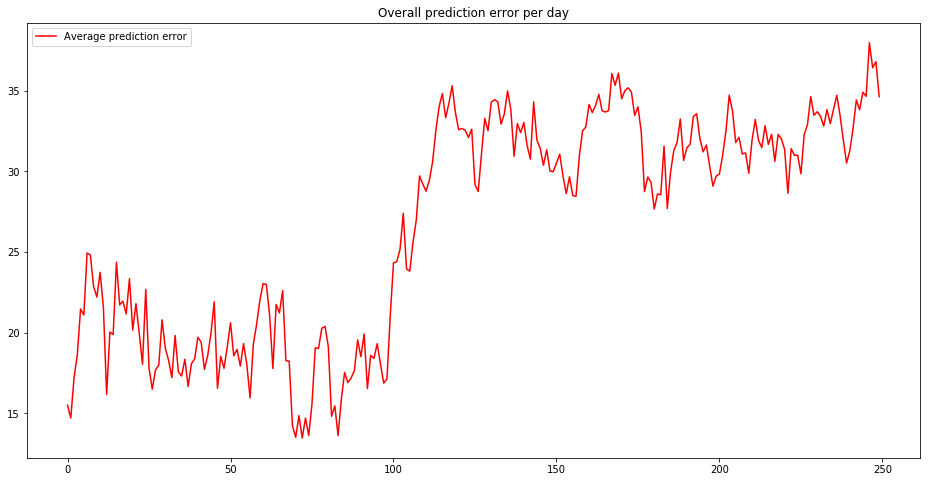

In [20]:
plt.figure(figsize=(16,8))
plt.plot(total_errors[1500], label='Average prediction error', color = 'red')
plt.legend(loc='upper left')
plt.title('Overall prediction error per day')

From the above graph, we can spot a spike in the error made by our model after more than 100 trading days and a surprising minimal error after about 80 days into the future, meaning the optimal prediction period to be in the first quarter of the following year.

# Basic Comparison technique
In this section, we will try to define a more intuitive comparison technique between our predictions and the actual ETF behavior by examining periodic changes in the closing price of the various ETFs.

In [113]:
def get_frequant_changes(stock_df):
    changes = {x:[] for x in ['year_changes','quarter_changes','month_changes','week_changes']}
    temp_counter = 0

    #set initial parameters
    for index, row in stock_df.iterrows():
        starting_day = int(row['Date'][-2:])
        starting_month = int(row['Date'][6:7])
        starting_year = int(row['Date'][:4])
        year_price,qurter_price, month_price,week_price = row['Close'],row['Close'],row['Close'],row['Close'] 
        break
    flag = True
    q_count = 0
    for index, row in stock_df.iterrows():
        current_day = float(row['Date'][-2:])
        current_month = float(row['Date'][6:7])
        current_year = float(row['Date'][:4])
        current_price = float(row['Close'])
        if flag:
            previous_day,previous_month,previous_year = current_day, current_month, current_year
            flag = False
            continue

        if (previous_day + 1) != current_day: #week break
            if current_day != 1:
                changes['week_changes'] += [((current_price - week_price) / week_price) * 100]
                week_price = current_price

        if previous_month  != current_month: #month break
            changes['month_changes'] += [((current_price - month_price) / month_price) * 100]
            month_price = current_price
            q_count += 1
            if q_count == 3: #end of quarter
                changes['quarter_changes'] += [((current_price - qurter_price) / qurter_price) * 100]
                qurter_price = current_price
                q_count = 0

        if previous_year != current_year: #year break
            changes['year_changes'] += [((current_price - year_price) / year_price) * 100]
            year_price = current_price

        previous_day,previous_month,previous_year = current_day, current_month, current_year
    return changes
    

In [114]:
def get_complex_future_trend_prediction(stock_df, predictions):
    future_trends ={x:'do somthing' for x in ['week_changes','month_changes','quarter_changes','year_changes']}
    indiffrence_ranges = {x:[] for x in ['week_changes','month_changes','quarter_changes','year_changes']}
    
    first_price = np.array(stock_df['Open'])[-1]
    final_vals = translate(stock_df, predictions, 100)
    changes = get_frequant_changes(stock_df)
    
    for k, l in zip(future_trends.keys(), [5,25,75,250]):
        temp_change = ((final_vals[l -1] - first_price) / first_price) * 100
        if l in [5,25]:
            if np.quantile(changes[k], 0.15) <= temp_change <= np.quantile(changes[k], 0.85):
                future_trends[k] = 'HOLD'
            elif temp_change < np.quantile(changes[k], 0.15):
                future_trends[k] = 'HARD SELL'
            else:
                future_trends[k] = 'HARD BUY'
        else: # quarter and year changes
            if np.quantile(changes[k], 0.15) <= temp_change <= np.quantile(changes[k], 0.85): #holding range
                if l == 75: #quarter
                    if temp_change > 5:
                        future_trends[k] = 'HARD BUY'
                    else:
                        future_trends[k] = 'HOLD'
                else: #year
                    if temp_change > 10:
                        future_trends[k] = 'HARD BUY'
                    else:
                        future_trends[k] = 'HOLD'
            elif temp_change < np.quantile(changes[k], 0.15):
                future_trends[k] = 'HARD SELL'
            else:
                future_trends[k] = 'HARD BUY'
    return future_trends

In [115]:
def get_true_trends(etf, etf_dict, training_days, prediction_days):
    future_trends ={x:'do somthing' for x in ['week_changes','month_changes','quarter_changes','year_changes']}
    indiffrence_ranges = {x:[] for x in ['week_changes','month_changes','quarter_changes','year_changes']}
    
    temp_df = etf_dict[etf].iloc[-(training_days + prediction_days):-prediction_days, :]
    true_vals_df = etf_dict[etf].iloc[-prediction_days:, :]
    first_price = np.array(temp_df['Open'])[-1] #start predicting from the last known open price
    changes = get_frequant_changes(temp_df)
    true_vals = true_vals_df['Close'].values
    for k, l in zip(future_trends.keys(), [5,25,75,250]):
        indiffrence_ranges[k] = np.quantile(changes[k], [0.15,0.85])
        true_change = ((true_vals[l - 1] - first_price ) / first_price) * 100
        if l in [5,25]:
            if np.quantile(changes[k], 0.15) <= true_change <= np.quantile(changes[k], 0.85):
                future_trends[k] = 'HOLD'
            elif true_change < np.quantile(changes[k], 0.15):
                future_trends[k] = 'HARD SELL'
            else:
                future_trends[k] = 'HARD BUY'
        else: # quarter and year changes
            if np.quantile(changes[k], 0.15) <= true_change <= np.quantile(changes[k], 0.85): #holding range
                if l == 75: #quarter
                    if true_change > 5:
                        future_trends[k] = 'HARD BUY'
                    else:
                        future_trends[k] = 'HOLD'
                else: #year
                    if true_change > 10:
                        future_trends[k] = 'HARD BUY'
                    else:
                        future_trends[k] = 'HOLD'
            elif true_change < np.quantile(changes[k], 0.15):
                future_trends[k] = 'HARD SELL'
            else:
                future_trends[k] = 'HARD BUY'
    return future_trends, indiffrence_ranges

In [118]:
def get_f1_acc_scores(suggested_preds, stock_dic):
    predicted_trends = {x:[] for x in ['week_changes','month_changes','quarter_changes','year_changes']}
    true_trends =  {x:[] for x in ['week_changes','month_changes','quarter_changes','year_changes']}
    training_days = 1500
    prediction_days = 250
    for k,val in suggested_preds.items():
        temp_df = stock_dic[k].iloc[-(training_days + prediction_days):-prediction_days, :]
        temp_predicted_changes = get_complex_future_trend_prediction(temp_df,val)
        temp_true_trends, indiffrence_ranges = get_true_trends(k, stock_dic, training_days, prediction_days)
        for tk in true_trends.keys():
            predicted_trends[tk] += [temp_predicted_changes[tk]]
            true_trends[tk] += [temp_true_trends[tk]]
    for k in true_trends.keys():
        print(k,'accuracy is: ', accuracy_score(true_trends[k], predicted_trends[k]),' f1 score is:',f1_score(true_trends[k], predicted_trends[k],average='macro'))

Before inspecting our model with that method let's use it to analyze our baseline models:

In [246]:
base_f1_acc_scores = {}

prediction_days = 250
for method in ['AR','MA','ARMA','ARIMA']:
    for training_days in [1000]:
        predicted_trends = {x:[] for x in ['week_changes','month_changes','quarter_changes','year_changes']}
        true_trends =  {x:[] for x in ['week_changes','month_changes','quarter_changes','year_changes']}
        for k,val in baseline_preds.items():
            if k[1] == method and k[2] == training_days:
                temp_df = etf_dict[k[0]].iloc[-(training_days + prediction_days):-prediction_days, :]
                temp_predicted_changes = get_complex_future_trend_prediction_baseline(temp_df,val)
                temp_true_trends, indiffrence_ranges = get_true_trends(k[0], etf_dict, training_days, prediction_days)
                for tk in true_trends.keys():
                    predicted_trends[tk] += [temp_predicted_changes[tk]]
                    true_trends[tk] += [temp_true_trends[tk]]

        for m in true_trends.keys():
            base_f1_acc_scores[(method,m)] = 'accuracy score is: ' + str(accuracy_score(true_trends[m], predicted_trends[m])) +' F1 score is: '+ str(f1_score(true_trends[m], predicted_trends[m],average='macro'))

for k in base_f1_acc_scores.keys():
    print(k, base_f1_acc_scores[k])

('AR', 'week_changes') accuracy score is: 0.5 F1 score is: 0.3333333333333333
('AR', 'month_changes') accuracy score is: 0.1 F1 score is: 0.06060606060606061
('AR', 'quarter_changes') accuracy score is: 0.3 F1 score is: 0.2222222222222222
('AR', 'year_changes') accuracy score is: 0.3 F1 score is: 0.3
('MA', 'week_changes') accuracy score is: 0.2 F1 score is: 0.16666666666666666
('MA', 'month_changes') accuracy score is: 0.1 F1 score is: 0.06060606060606061
('MA', 'quarter_changes') accuracy score is: 0.1 F1 score is: 0.06666666666666667
('MA', 'year_changes') accuracy score is: 0.3 F1 score is: 0.3
('ARMA', 'week_changes') accuracy score is: 0.5 F1 score is: 0.2380952380952381
('ARMA', 'month_changes') accuracy score is: 0.1 F1 score is: 0.06060606060606061
('ARMA', 'quarter_changes') accuracy score is: 0.3 F1 score is: 0.19999999999999998
('ARMA', 'year_changes') accuracy score is: 0.3 F1 score is: 0.3
('ARIMA', 'week_changes') accuracy score is: 0.5 F1 score is: 0.3333333333333333
('

Not a great success, so let's move on to our best model and see if it performed any better:

In [249]:
file_name = open('total_symbols_predictions', 'rb')
suggested_preds = pickle.load(file_name)

In [252]:
predicted_trends = {x:[] for x in ['week_changes','month_changes','quarter_changes','year_changes']}
true_trends =  {x:[] for x in ['week_changes','month_changes','quarter_changes','year_changes']}

training_days = 1500
prediction_days = 250
for k,val in suggested_preds.items():
    if k[1] == 2 and k[2] == 1500:
        temp_df = etf_dict[k[0]].iloc[-(training_days + prediction_days):-prediction_days, :]
        temp_predicted_changes = get_complex_future_trend_prediction(temp_df,val)
        temp_true_trends, indiffrence_ranges = get_true_trends(k[0], etf_dict, training_days, prediction_days)
        for tk in true_trends.keys():
            predicted_trends[tk] += [temp_predicted_changes[tk]]
            true_trends[tk] += [temp_true_trends[tk]]

In [253]:
for k in true_trends.keys():
    print(k,'accuracy score is: ', accuracy_score(true_trends[k], predicted_trends[k]),' f1 score is:',f1_score(true_trends[k], predicted_trends[k],average='macro'))

week_changes accuracy score is:  0.4  f1 score is: 0.2424242424242424
month_changes accuracy score is:  0.2  f1 score is: 0.14074074074074072
quarter_changes accuracy score is:  0.8  f1 score is: 0.7916666666666665
year_changes accuracy score is:  0.5  f1 score is: 0.2564102564102564


Examining our model performance, we can spot that quarterly changes in the ETF's are the easiest to predict with 80% accuracy and 0.79 F1 score!

Moreover, that finding approves the results of our "best prediction period" to be around 80 trading days when 75 trading days make for a quarter of a year (full trading year are composed of 252 trading days).

# Advanced Part

In this part, we will try to predict the prices of the "XLK" (technology sector fund) by predicting the prices of it's composing stocks including Apple, Microsoft, IBM and more.

At first, let's have a look on our best prediction yet, regarding the XLK fund:

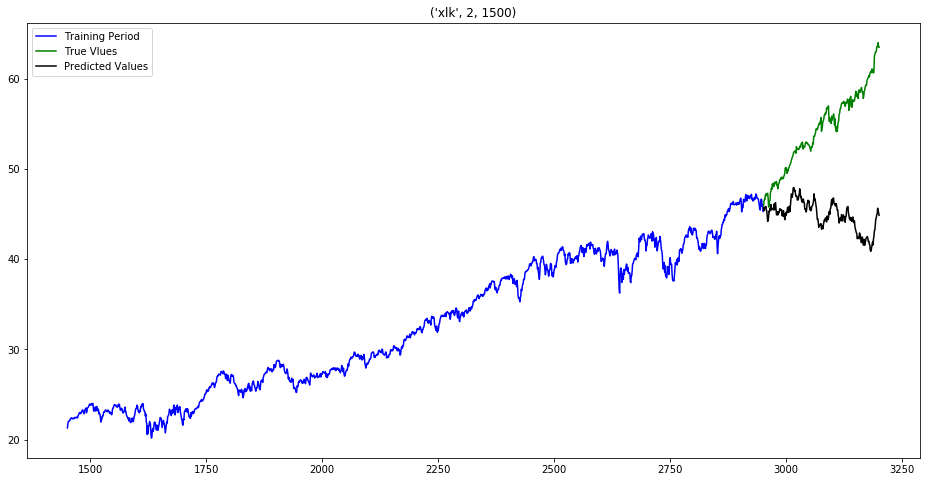

In [219]:
plot_graphs_and_predictions(('xlk',2,1500),1500,best_predictions, etf_dict)

Now, we will try to recreate the XLK fund by plotting the composing stocks separately with regards to their percentage in the fund: (Source https://www.etf.com/XLK#overview)

In [21]:
xlk_stocks = {'msft':0.20, 'aapl':0.17, 'v':0.06, 'ma':0.05, 'intc':0.04, 'csco':0.04, 'adbe':0.03, 'crm':0.03, 'orcl':0.03,  'acn':0.03 ,'ibm': 0.02, 'txn': 0.02, 'avgo':0.02, 'nvda':0.02, 'qcom': 0.02, 'fis':0.015, 'adp':0.01}  

In [22]:
stock_dict = get_stock_data(xlk_stocks.keys())

In [23]:
strange_vals = []
for i in range(1500):
    temp_price = sum([stock_dict[s].iloc[-(1750- i),:]['Close'] * xlk_stocks[s] for s in xlk_stocks.keys()])
    strange_vals.append(temp_price)

strange_preds = []
for i in range(250):
    temp_price = sum([stock_dict[s].iloc[-(250 - i),:]['Close'] * xlk_stocks[s] for s in xlk_stocks.keys()])
    strange_preds.append(temp_price)
    

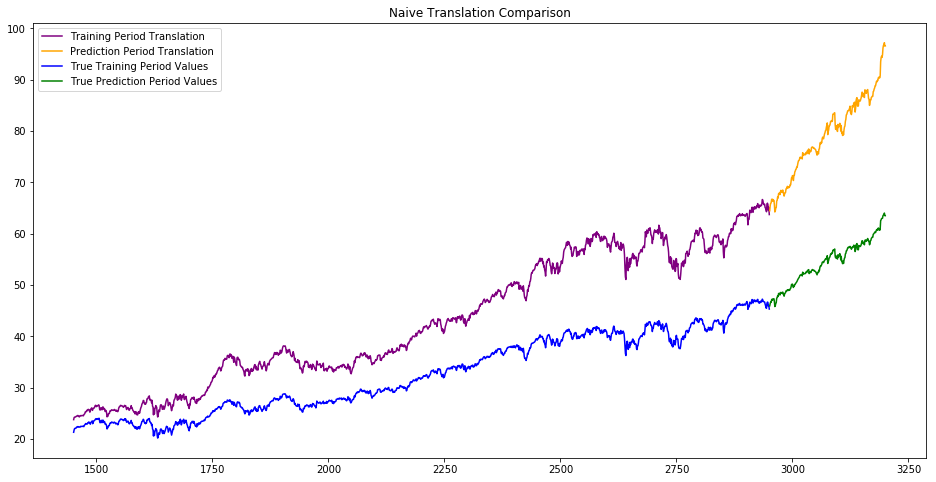

In [24]:
temp_df = etf_dict['xlk'].iloc[-(1500 + 250):-250, :]
true_vals = etf_dict['xlk'].iloc[-250:,:]
stranger_things = pd.DataFrame(strange_vals,index = temp_df['Close'].index,columns=['Prediction'])
stranger_preds =  pd.DataFrame(strange_preds,index = true_vals['Close'].index,columns=['Prediction'])
plt.figure(figsize=(16,8))
plt.plot(stranger_things['Prediction'], label = 'Training Period Translation', color = 'purple')
plt.plot(stranger_preds['Prediction'], label = 'Prediction Period Translation', color = 'orange')
plt.plot(temp_df['Close'], label='True Training Period Values', color = 'b')
plt.plot(true_vals['Close'], label='True Prediction Period Values', color = 'g')
plt.title('Naive Translation Comparison')
plt.legend(loc='upper left')

As we can see from the above figure, simply plotting the stocks according to their percentage is not enough.
Doing so, we only calculate the NAV (Net Asset Value) of the fund without taking into account the TER (Total Expense Ratio), the total amount of cash in the fund and more.
unfortunately, in this method, we can spot a clear and growing difference between our "translation" and the original fund price.

To account for this mismatch, we will use linear regression as sort of  "damage control" to make our "translation" closer to the true value of the fund:

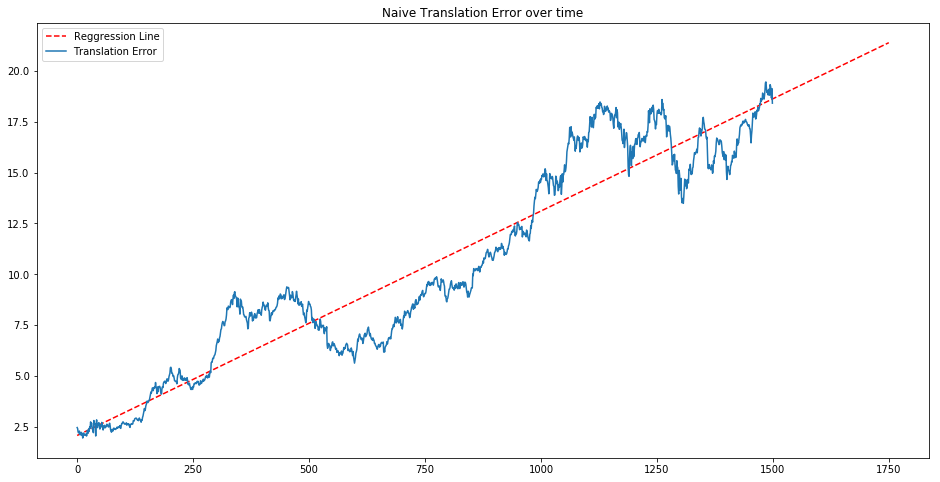

In [25]:
from sklearn.linear_model import LinearRegression
diffs = np.array(strange_vals) - np.array(etf_dict['xlk'].iloc[-(1500 + 250):-250, :]['Close'].values)
model = LinearRegression().fit(np.array(list(range(1500))).reshape((-1,1)),diffs)
intercept = model.intercept_
slope = model.coef_
plt.figure(figsize=(16,8))
x = np.linspace(0, 1750, 1000)
plt.plot(x, intercept + slope * x, '--r', label = 'Reggression Line')
plt.plot(diffs, label = 'Translation Error')
plt.title('Naive Translation Error over time')
plt.legend(loc='upper left')

Now, let's try to translate the actual values of our stocks in the prediction period using the suggested method:

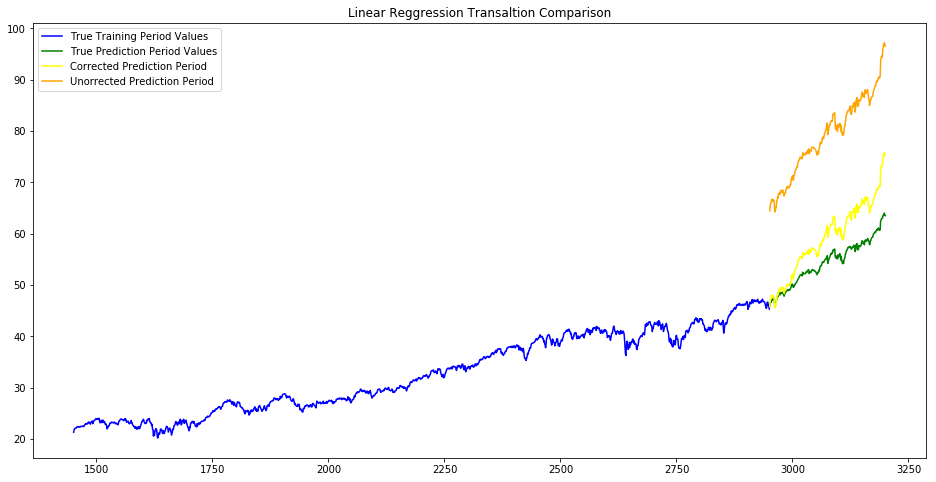

In [36]:
corrected_preds = [x - (intercept + (i + 1500) * slope) for i,x in enumerate(strange_preds)]
corrected =  pd.DataFrame(corrected_preds,index = true_vals['Close'].index,columns=['Prediction'])
plt.figure(figsize=(16,8))
plt.plot(temp_df['Close'], label='True Training Period Values', color = 'b')
plt.plot(true_vals['Close'], label='True Prediction Period Values', color = 'g')
plt.plot(corrected['Prediction'], label='Corrected Prediction Period', color = 'yellow')
plt.plot(stranger_preds['Prediction'], label='Unorrected Prediction Period', color = 'orange')
plt.title('Linear Reggression Translation Comparison')
plt.legend(loc='upper left')

## Predicting the stocks separately
We will use our best model configuration in order to predict each individual stock price:

In [ ]:
stock_scores = {}
stock_predictions = {}
hidden_states = 2
num_symbols = 2
training_days = 1500
for stock in xlk_stocks.keys():
    #training
    start = time.time()
    training =  get_training_symbols(stock_dict[stock], training_days, num_symbols)
    temp_enu, temp_reverse_enu = enumerate_features(training)
    predicted_data = predict(250, hidden_states, training, temp_enu, temp_reverse_enu) #predict 250 days into the future
    predicted = predicted_data[-250:]
    end = time.time()
    stock_predictions[stock] = predicted
    print(stock,' training time is: ', end - start)

    #prediction and translation       
    temp_df = stock_dict[stock].iloc[-(training_days + 250):-250, :]
    temp_true_vals = stock_dict[stock].iloc[-250:,:]['Close'].values
    final_vals = translate(temp_df, predicted, 100) #number of bootstrap iterations = 100
    
    #score calculation
    temp_score = get_MAPE_score(temp_true_vals, final_vals)
    print(stock,' score is: ',temp_score)
    stock_scores[stock] = temp_score

In [37]:
file_name = open('stock_scores', 'rb')
stock_scores =  pickle.load(file_name)
file_name = open('stock_predictions', 'rb')
stock_predictions = pickle.load(file_name)

In [38]:
stock_translation = {}
for k, val in stock_predictions.items():
    temp_df = stock_dict[k].iloc[-(1500 + 250):-250, :]
    stock_translation[k] = translate(temp_df, val, 100)

In [39]:
stock_preds = []
for i in range(250):
    temp_price = sum([stock_translation[s][-(250 - i)] * xlk_stocks[s] for s in xlk_stocks.keys()])
    stock_preds.append(temp_price)

Finally, using linear regression to compensate for "translation error" we will plot all our predictions together to recreate the XLK fund:

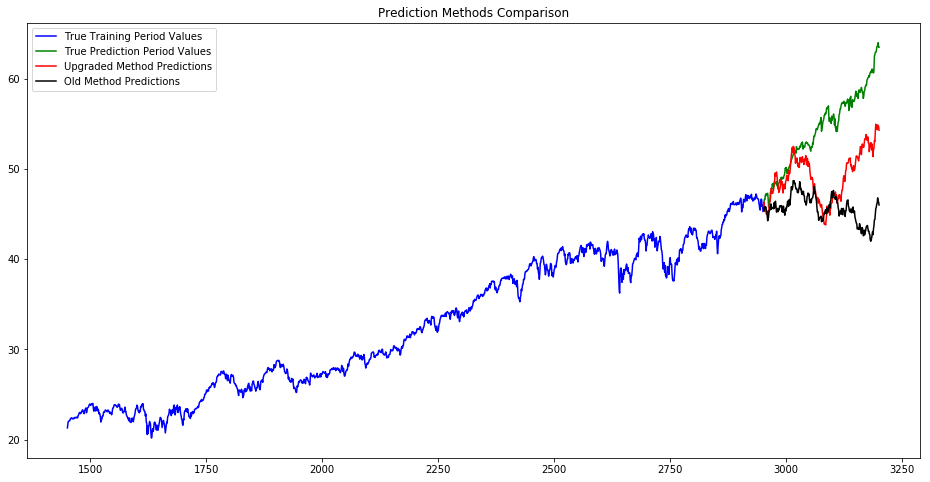

In [43]:
true_vals = etf_dict['xlk'].iloc[-250:,:]
temp_df = etf_dict['xlk'].iloc[-(1500 + 250):-250, :]
corrected_stock_preds = [x - (intercept + (i + 1500) * slope) for i,x in enumerate(stock_preds)]
corrected_stock_preds_df =  pd.DataFrame(corrected_stock_preds,index = true_vals['Close'].index,columns=['Prediction'])

original_vals = translate(temp_df, best_predictions[('xlk',2,1500)], 100)
translated = pd.DataFrame(original_vals,index = true_vals['Close'].index,columns=['Prediction'])

plt.figure(figsize=(16,8))
plt.plot(temp_df['Close'], label='True Training Period Values', color = 'b')
plt.plot(true_vals['Close'], label='True Prediction Period Values', color = 'g')
plt.plot(corrected_stock_preds_df['Prediction'], label='Upgraded Method Predictions', color = 'r')
plt.plot(translated['Prediction'], label='Old Method Predictions', color = 'black')
plt.title('Prediction Methods Comparison')
plt.legend(loc='upper left')

We can see that the new method resembles the true value of the fund better than our previous attempt.

Now, let's compare the errors of the two methods and their MAPE scores to get a better understanding:

In [141]:
corrected_stock_preds_lis = [x[0] for x in corrected_stock_preds]
prediction_error_corrected = np.array(etf_dict['xlk'].iloc[-250:, :]['Close'].values) -  np.array(corrected_stock_preds_lis) 
prediction_error_original = np.array(etf_dict['xlk'].iloc[-250:, :]['Close'].values) - original_vals

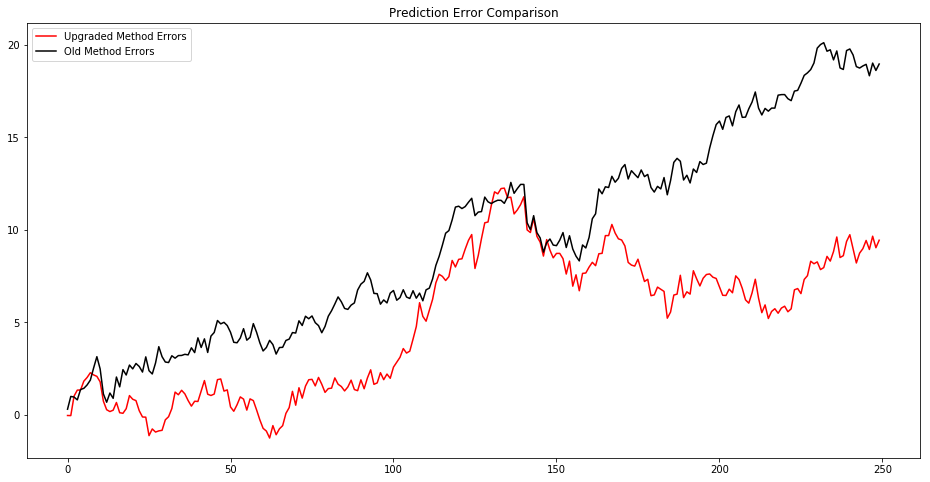

In [221]:
plt.figure(figsize=(16,8))
plt.plot(prediction_error_corrected, label ='Upgraded Method Errors',  color = 'red')
plt.plot(prediction_error_original, label ='Old Method Errors', color = 'black')
plt.title('Prediction Error Comparison')
plt.legend(loc='upper left')

In [46]:
xlk_true_vals = etf_dict['xlk'].iloc[-250:,:]['Close'].values
print('Original MAPE score: ', get_MAPE_score(xlk_true_vals, original_vals))
print('Upgraded method MAPE score: ', get_MAPE_score(xlk_true_vals, corrected_stock_preds))

Original MAPE score:  15.407698149158271
Upgraded method MAPE score:  10.61374890445389


It's visible that the prediction error of our new method is consistently lower than that of our best model yet, and combined with lower MAPE score ( 10.6 against  15.4) we proved the new method to be superior.

# Creative Part

In this part, we will try to use the leading financial institutions' recommendations for promising stocks over the years to further improve our prediction method.
Moreover, we will analyze the predictions made by leading financial investors and commentators for "10 best stocks" for the year 2017 and compare them to our best predictions. 

In [144]:
best_for_2016 = ['pfe','bac','hon','aig','ddaiy','tel','brs','kmt','kkr','tjx'] #http://money.com/money/4161047/great-stocks-buy-2016/
best_for_2015 = ['abm','ne','yhoo','googl','amba','psec','pzzi','aapl','odfl','fb'] #https://www.nasdaq.com/articles/10-best-stocks-buy-2015-2015-01-05
best_for_2014 = ['msft','exel','rmti','crm','ftk','fdx','nke','nfg','twtr','ibm'] #https://www.nasdaq.com/articles/10-stocks-watch-2014-2013-11-19
best_for_2013 = ['ddaiy','myl','intc','qcom','shw','gldd','fmx','two','vale','nflx'] #https://investorplace.com/best-stocks-for-2013/
best_for_2012 = ['cat','fdx','hsy','cof','mako','msft','arco','tkc','aa','std'] #https://www.forbes.com/sites/tomtaulli/2011/12/27/experts-top-stock-picks-for-2012/#3ff2733f29af
best_dic = {2016:best_for_2016, 2015:best_for_2015, 2014:best_for_2014, 2013:best_for_2013, 2012:best_for_2012}

In [65]:
all_tickers = best_for_2016 + best_for_2015 + best_for_2014 + best_for_2013 + best_for_2012
unique_bests = set([b for b in all_tickers])

In [96]:
best_stocks_dict = get_stock_data(unique_bests)

Let's focus on that group of stocks, including recurring promising stocks and other well known brands e.g Netflix, Caterpiller and more:

In [97]:
target_stocks = ['fdx','msft','bac','aapl','fmx','qcom','nflx','cat','pfe','aapl']

Now, let's add for each stock data frame a new symbol representing the predicted behavior over the years where 'U' stands for Up and 'R' stands for Regular:

In [98]:
for s in target_stocks:
    temp_df = best_stocks_dict[s]
    best_years = [k for k in best_dic.keys() if s in best_dic[k]]
    temp_df['New Char'] = ['U' if x in best_years else 'R' for x in temp_df['Year']]
    temp_df['Two_Symbols'] = temp_df['Two_Symbols'] + temp_df['New Char']   

Finally, we will predict each stock price:

In [ ]:
upgradeed_predictions = {}
upgradeed_scores = {}
hidden_states = 2
num_symbols = 2
training_days = 1500
for stock in target_stocks:
    #training
    start = time.time()
    training =  get_training_symbols(best_stocks_dict[stock], training_days, num_symbols)
    temp_enu, temp_reverse_enu = enumerate_features(training)
    predicted_data = predict(250, hidden_states, training, temp_enu, temp_reverse_enu) #predict 250 days into the future
    predicted = predicted_data[-250:]
    end = time.time()
    upgradeed_predictions[stock] = predicted
    print(stock,' training time is: ', end - start)

    #prediction and translation       
    temp_df = best_stocks_dict[stock].iloc[-(training_days + 250):-250, :]
    temp_true_vals = best_stocks_dict[stock].iloc[-250:,:]['Close'].values
    final_vals = translate(temp_df, predicted, 100) #number of bootstrap iterations = 100
    
    #score calculation
    temp_score = get_MAPE_score(temp_true_vals, final_vals)
    print(stock,' score is: ',temp_score)
    upgradeed_scores[stock] = temp_score

In [103]:
file_name = open('upgraded_scores', 'rb')
upgraded_scores =  pickle.load(file_name)
file_name = open('upgraded_predictions', 'rb')
upgraded_predictions =  pickle.load(file_name)

Now, let's compare these results to our normal predictions, using MAPE, accuracy and F1 measure:

In [109]:
file_name = open('regular_scores', 'rb')
regular_scores =  pickle.load(file_name)
file_name = open('regular_predictions', 'rb')
regular_predictions =  pickle.load(file_name)

In [111]:
comparison_scores = {'regular':0, 'upgraded':0}
for k in regular_scores.keys():
    comparison_scores['regular'] += regular_scores[k]
    comparison_scores['upgraded'] += upgradeed_scores[k]
print(comparison_scores)

{'regular': 143.36113401811053, 'upgraded': 136.16127465393544}


In [119]:
get_f1_acc_scores(regular_predictions, best_stocks_dict)

week_changes accuracy is:  0.5555555555555556  f1 score is: 0.2380952380952381
month_changes accuracy is:  0.5555555555555556  f1 score is: 0.2380952380952381
quarter_changes accuracy is:  0.4444444444444444  f1 score is: 0.3148148148148148
year_changes accuracy is:  0.3333333333333333  f1 score is: 0.26666666666666666


In [120]:
get_f1_acc_scores(upgradeed_predictions, best_stocks_dict)

week_changes accuracy is:  0.6666666666666666  f1 score is: 0.26666666666666666
month_changes accuracy is:  0.6666666666666666  f1 score is: 0.5897435897435898
quarter_changes accuracy is:  0.5555555555555556  f1 score is: 0.41269841269841273
year_changes accuracy is:  0.4444444444444444  f1 score is: 0.3151515151515151


Examining the results of our comparison we can spot a slight improvement in the MAPE measure in favor of our improved method and overall better performance using our intuitive periodic comparison method where the monthly changes demonstrate the highest improvement (0.23 to 0.58 increase in F1 measure).

## "Top 10 Stocks for 2017" recommendations analysis 

Why bother with computational learning? let's just take the word of professionals and have a look at their recommendations for the best stocks for the year 2017.

For the sake of simplicity, in this section, we consider a stock recommendation to be correct if it's total growth over the year is greater than 10%

In [146]:
best_for_2017_cnvc = ['abt','googl','bdx','cvs','xom','jnj','low','msft','sfm','utx'] #https://www.cnbc.com/2016/12/29/top-10-stocks-for-2017-commentary.html
best_for_2017_investorplace = ['lrcx','vz','pru','bac','unh','wmt','hd','googl','lmt','has'] #https://investorplace.com/2016/12/10-best-stocks-to-buy-2017/
best_for_2017_money = ['schw','nov','unp','prblx','cvs','gild','intc','agco','sci','ttc','mtn','uovey'] #http://money.com/money/4616745/investing-stock-picks-from-pros/

In [147]:
all_recs = best_for_2017_cnvc + best_for_2017_investorplace + best_for_2017_money
unique_recs = set([rec for rec in all_recs])
rec_stocks_dict = get_stock_data(unique_recs)

In [170]:
percent_changes = {}
for k in rec_stocks_dict.keys():
    percent_changes[k] = (float(rec_stocks_dict[k].iloc[-1]['Close'] - rec_stocks_dict[k].iloc[-218]['Close'] ) / rec_stocks_dict[k].iloc[-218]['Close']) * 100

In [184]:
print('Overall predictions accuracy for stocks with 10% growth:', sum([1 for x in percent_changes.values() if x >= 10]) / len(unique_recs))

Overall predictions accuracy for stocks with 10% growth: 0.6666666666666666


In [175]:
print('Average stock price change in precents: ', sum(percent_changes.values()) / len(unique_recs))

Average stock price change in precents:  18.559615755524433


In [185]:
print('best recommendation for 2017 is:',[k for k in percent_changes.keys() if percent_changes[k] == max(percent_changes.values())][0],'(Lam Research Corporation) with ',max(percent_changes.values()), '% growth' ) 

best recommendation for 2017 is: lrcx (Lam Research Corporation) with  95.15385339230262 % growth


In [186]:
print('Worst recommendation for 2017 is:',[k for k in percent_changes.keys() if percent_changes[k] == min(percent_changes.values())][0],'(Verizon Communications Inc) with ',min(percent_changes.values()), '% lost' ) 

Worst recommendation for 2017 is: vz (Verizon Communications Inc) with  -13.775216138328519 % lost
